# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

## Data Gathering

In [2]:
tweets_df = pd.read_csv('twitter-archive-enhanced.csv', dtype={"tweet_id": str})
tweets_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
#importing tsv file as csv with tab delimeter
dog_bread_df = pd.read_csv('image-predictions.tsv', sep='\t', dtype={"tweet_id": str})
dog_bread_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [4]:
# import tweepy
# from tweepy import OAuthHandler
# import json
# from timeit import default_timer as timer
# import requests
# import pandas as pd

# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = credential.consumer_key
# consumer_secret = credential.consumer_secret
# access_token = credential.access_token
# access_secret = credential.access_secret

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)

# # NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# # df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# # change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# # NOTE TO REVIEWER: this student had mobile verification issues so the following
# # Twitter API code was sent to this student from a Udacity instructor
# # Tweet IDs for which to gather additional data via Twitter's API
# url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# req = requests.get(url)
# req_data = req.content

# with open("data_stage.csv", "wb") as outfile:
#     outfile.write(req_data)

# df_1 = pd.read_csv("data_stage.csv", delimiter="\t")
# tweet_ids = df_1.tweet_id.values
# len(tweet_ids)

# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         #except tweepy.TweepError as e:
#         #except tweepy.errors.TweepError as e:
#         except tweepy.errors.TweepyException as e: 
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

In [5]:
tweet_extended_df = pd.read_json("tweet_json.txt",lines=True, dtype ={"id_str": str})[:-1]
tweet_extended_df.head()


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [6]:
tweet_extended_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2353 non-null   datetime64[ns, UTC]
 1   id                             2353 non-null   int64              
 2   id_str                         2353 non-null   object             
 3   full_text                      2353 non-null   object             
 4   truncated                      2353 non-null   bool               
 5   display_text_range             2353 non-null   object             
 6   entities                       2353 non-null   object             
 7   extended_entities              2072 non-null   object             
 8   source                         2353 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [83]:
all_df = tweets_df.set_index('tweet_id').join(tweet_extended_df.set_index('id_str'),lsuffix='_basic', rsuffix='_extended')
all_df = all_df.join(dog_bread_df.set_index('tweet_id'),lsuffix='', rsuffix='_breed')
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   in_reply_to_status_id_basic     78 non-null     float64            
 1   in_reply_to_user_id_basic       78 non-null     float64            
 2   timestamp                       2356 non-null   object             
 3   source_basic                    2356 non-null   object             
 4   text                            2356 non-null   object             
 5   retweeted_status_id             181 non-null    float64            
 6   retweeted_status_user_id        181 non-null    float64            
 7   retweeted_status_timestamp      181 non-null    object             
 8   expanded_urls                   2297 non-null   object             
 9   rating_numerator                2356 non-null   int64      

In [8]:
all_df.sample(10)

,in_reply_to_status_id_basic,in_reply_to_user_id_basic,timestamp,source_basic,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,,,
667174963120574464,NaN,NaN,2015-11-19 02:58:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Clarence. His face says he doesn't wan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667174963...,9,...,1.0,toy_poodle,0.266437,True,Chihuahua,0.243223,True,bluetick,0.072806,True
790987426131050500,NaN,NaN,2016-10-25 18:44:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Misty. She has a cowboy hat on her nos...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/790987426...,12,...,1.0,cocker_spaniel,0.349195,True,flat-coated_retriever,0.309535,True,Newfoundland,0.104768,True
670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002...,9,...,1.0,seat_belt,0.952258,False,toy_terrier,0.038872,True,beagle,0.003226,True
875144289856114688,NaN,NaN,2017-06-15 00:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Nugget and Hank. Nugget took Hank's bone....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/875144289...,13,...,1.0,Siberian_husky,0.245048,True,Pembroke,0.223716,True,dingo,0.160753,False
672267570918129665,NaN,NaN,2015-12-03 04:14:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you accidentally open up the front facing...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672267570...,10,...,1.0,Irish_terrier,0.716932,True,miniature_pinscher,0.051234,True,Airedale,0.044381,True
736010884653420544,NaN,NaN,2016-05-27 01:47:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Right after you graduate vs when you remember ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/736010884...,10,...,2.0,golden_retriever,0.553901,True,Labrador_retriever,0.119475,True,bluetick,0.077475,True
750071704093859840,NaN,NaN,2016-07-04 21:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pause your cookout and admire this pupper's ni...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750071704...,10,...,2.0,redbone,0.382113,True,malinois,0.249943,True,miniature_pinscher,0.070926,True
679862121895714818,NaN,NaN,2015-12-24 03:12:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Dammit hooman I'm jus trynna lik the fler"" 11...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/679862121...,11,...,1.0,EntleBucher,0.523206,True,Greater_Swiss_Mountain_dog,0.431657,True,Appenzeller,0.044208,True
667160273090932737,NaN,NaN,2015-11-19 01:59:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bradlay. He is a Ronaldinho Matsuyama ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667160273...,11,...,1.0,golden_retriever,0.471351,True,miniature_poodle,0.091992,True,standard_poodle,0.087385,True


In [9]:
#  copies of original pieces of data
all_df_copy=all_df.copy()

## Assessing Data

***Round 1: Assessment***
* Quality Issues:
    - Null values recorded as None and NaN (was noted while gathering data)

In [10]:
all_df.index.duplicated().any()

False

In [11]:
all_df.isnull().sum()

in_reply_to_status_id_basic       2278
in_reply_to_user_id_basic         2278
timestamp                            0
source_basic                         0
text                                 0
retweeted_status_id               2175
retweeted_status_user_id          2175
retweeted_status_timestamp        2175
expanded_urls                       59
rating_numerator                     0
rating_denominator                   0
name                                 0
doggo                                0
floofer                              0
pupper                               0
puppo                                0
created_at                           3
id                                   3
full_text                            3
truncated                            3
display_text_range                   3
entities                             3
extended_entities                  284
source_extended                      3
in_reply_to_status_id_extended    2278
in_reply_to_status_id_str

***Round 1: Cleaning***
* Unify Null value to be NaN.

In [12]:
all_df.replace('None', np.nan, inplace=True)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   in_reply_to_status_id_basic     78 non-null     float64            
 1   in_reply_to_user_id_basic       78 non-null     float64            
 2   timestamp                       2356 non-null   object             
 3   source_basic                    2356 non-null   object             
 4   text                            2356 non-null   object             
 5   retweeted_status_id             181 non-null    float64            
 6   retweeted_status_user_id        181 non-null    float64            
 7   retweeted_status_timestamp      181 non-null    object             
 8   expanded_urls                   2297 non-null   object             
 9   rating_numerator                2356 non-null   int64      

***Round 2: Assessment***
* Quality issues:
    - Remove columns which holds no data, or very low amount of data as `contributors`, `coordinates`, `geo`, `place`, `in_reply_to_status_id_basic`, `in_reply_to_user_id_basic`, `in_reply_to_screen_name`, `in_reply_to_status_id_extended`, `in_reply_to_status_id_str`, `in_reply_to_user_id_extended`, `in_reply_to_user_id_str`, `quoted_status`, `quoted_status_id`, `quoted_status_id_str`, `quoted_status_permalink`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_id`, `retweeted_status`, `retweeted_status_timestamp`,`is_quote_status`
    - Drop duplicated columns as `created_at`, `source_extended`, `id`, `expanded_urls`

In [13]:
all_df[['timestamp', 'created_at']].sample(5)

,timestamp,created_at
tweet_id,,
696744641916489729,2016-02-08 17:17:22 +0000,2016-02-08 17:17:22+00:00
786729988674449408,2016-10-14 00:47:00 +0000,2016-10-14 00:47:00+00:00
829141528400556032,2017-02-08 01:35:19 +0000,2017-02-08 01:35:19+00:00
666407126856765440,2015-11-17 00:06:54 +0000,2015-11-17 00:06:54+00:00
667435689202614272,2015-11-19 20:14:03 +0000,2015-11-19 20:14:03+00:00


In [14]:
all_df[['source_basic','source_extended']].sample(10)

,source_basic,source_extended
tweet_id,,
847157206088847362,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
667188689915760640,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
684959798585110529,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
666996132027977728,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
677314812125323265,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
861383897657036800,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
705239209544720384,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
668480044826800133,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
668932921458302977,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."


In [15]:
all_df.source_basic.unique(), all_df.source_extended.unique()

(array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
        '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
        '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
        '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
       dtype=object),
 array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
        nan,
        '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
        '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
        '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
       dtype=object))

In [16]:
all_df.id.map(lambda x: '{:.0f}'.format(x)).sample(5)

tweet_id
856543823941562368    856543823941562368
747103485104099331    747103485104099328
727314416056803329    727314416056803328
680494726643068929    680494726643068928
668960084974809088    668960084974809088
Name: id, dtype: object

***Round 2: Cleaning***


* Drop columns with no/low volume of data

In [17]:
all_df.drop(columns=['contributors', 'coordinates', 'geo', 'place', 'in_reply_to_status_id_basic', 
                     'in_reply_to_user_id_basic', 'in_reply_to_screen_name', 'in_reply_to_status_id_extended', 
                     'in_reply_to_status_id_str', 'in_reply_to_user_id_extended', 'in_reply_to_user_id_str', 
                     'quoted_status', 'quoted_status_id','is_quote_status', 'quoted_status_id_str', 
                     'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_id', 'retweeted_status',
                     'retweeted_status_timestamp'], inplace=True)

* Drop duplicated columns

In [18]:
all_df.drop(columns=['created_at','source_extended','id','expanded_urls'], inplace=True)
all_df.sample(5)

,timestamp,source_basic,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,,,
798209839306514432,2016-11-14 17:03:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. His bow tie was too heavy for ...,13,10,Cooper,NaN,NaN,NaN,NaN,...,1.0,Pekinese,0.524583,True,Shih-Tzu,0.102931,True,Pomeranian,0.097893,True
773922284943896577,2016-09-08 16:33:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Heinrich (pronounced ""Pat""). He's a Bo...",12,10,Heinrich,NaN,NaN,NaN,NaN,...,1.0,Pomeranian,0.554331,True,Samoyed,0.432158,True,chow,0.003199,True
701889187134500865,2016-02-22 21:59:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bilbo. He's not emotionally prepared t...,11,10,Bilbo,NaN,NaN,NaN,NaN,...,1.0,French_bulldog,0.902856,True,Staffordshire_bullterrier,0.022634,True,soap_dispenser,0.011973,False
707693576495472641,2016-03-09 22:24:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jiminus. He's in a tub for some reason...,7,10,Jiminus,NaN,NaN,NaN,NaN,...,1.0,bathtub,0.499525,False,tub,0.488014,False,washbasin,0.009298,False
812372279581671427,2016-12-23 19:00:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Moe. He's a fetty woof. Got a cardboar...,13,10,Moe,NaN,NaN,NaN,NaN,...,2.0,golden_retriever,0.784873,True,cocker_spaniel,0.087788,True,Labrador_retriever,0.083275,True


In [19]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timestamp                      2356 non-null   object 
 1   source_basic                   2356 non-null   object 
 2   text                           2356 non-null   object 
 3   rating_numerator               2356 non-null   int64  
 4   rating_denominator             2356 non-null   int64  
 5   name                           1611 non-null   object 
 6   doggo                          97 non-null     object 
 7   floofer                        10 non-null     object 
 8   pupper                         257 non-null    object 
 9   puppo                          30 non-null     object 
 10  full_text                      2353 non-null   object 
 11  truncated                      2353 non-null   object 
 12  display_text_range    

In [20]:
# all_df.drop(columns=['full_text','truncated','display_text_range','entities','extended_entities','user',
#                      'retweet_count','favorite_count','favorited','retweeted',
#                      'possibly_sensitive','possibly_sensitive_appealable','lang'], inplace=True)

***Round 3 : Assessment***
* Quality issues:
    - convert `source_basic` feature into these values `iPhone`, `Twitter`, `Vine`, `TweetDeck`, as well rename it as `source` (noted in Round 1)
    - convert `timestamp` to be datetime and rename the column into `tweet_date` (Noted in Round 1)
    - convert columns `doggo`, `floofer`, `pupper`, `puppo` values into true/false


In [21]:
all_df[['doggo','floofer','pupper','puppo']].sample(10)

,doggo,floofer,pupper,puppo
tweet_id,,,,
668975677807423489,NaN,NaN,NaN,NaN
866334964761202691,NaN,NaN,NaN,NaN
887705289381826560,NaN,NaN,NaN,NaN
796387464403357696,NaN,NaN,NaN,NaN
696744641916489729,NaN,NaN,NaN,NaN
770655142660169732,NaN,NaN,NaN,NaN
772193107915964416,NaN,NaN,pupper,NaN
689905486972461056,NaN,NaN,pupper,NaN
694352839993344000,NaN,NaN,NaN,NaN


In [22]:
all_df.doggo.unique(), all_df.floofer.unique(), all_df.pupper.unique(), all_df.puppo.unique()

(array([nan, 'doggo'], dtype=object),
 array([nan, 'floofer'], dtype=object),
 array([nan, 'pupper'], dtype=object),
 array([nan, 'puppo'], dtype=object))

***Round 3: Cleaning***



* rename `source_basic` to `source` and rename values to `iPhone`, `Twitter`, `Vine`, `TweetDeck`


In [23]:
all_df.source_basic.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>','iPhone',inplace=True)
all_df.source_basic.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','Twitter', inplace=True)
all_df.source_basic.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>','Vine', inplace=True)
all_df.source_basic.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>','Tweetdeck', inplace=True)
all_df.rename(columns={"source_basic": "source"}, inplace=True)

In [24]:
all_df.source.unique()

array(['iPhone', 'Twitter', 'Vine', 'Tweetdeck'], dtype=object)

* rename `timestamp` to `tweet_date` and convert date to datetime

In [25]:
# all_df.timestamp = pd.to_datetime(all_df['timestamp'])
all_df.rename(columns={'timestamp':'tweet_date'}, inplace=True)

* Convert `doggo`, `floofer`, `pupper`, `puppo` values into true/false

In [26]:
all_df.doggo.replace(np.nan, False, inplace=True)
all_df.floofer.replace(np.nan, False,inplace=True)
all_df.pupper.replace(np.nan, False,inplace=True)
all_df.puppo.replace(np.nan, False,inplace=True)

In [27]:
all_df.doggo.replace('doggo', True, inplace=True)
all_df.floofer.replace('floofer', True,inplace=True)
all_df.pupper.replace('pupper', True,inplace=True)
all_df.puppo.replace('puppo', True,inplace=True)

***Round 4: Assessment***
* Quality issues:
    - validate and correct rating numerator and denominator, and normalize denominator if possible. (Requires Visual Assessment)
    - fix dogs with more than 1 age stage of(`doggo`, `floofer`, `pupper`, `puppo`). (Requires Visual Assessment)
* Tideness issues:
    - group age stages (`doggo`, `floofer`, `pupper`, `puppo`) into one column as `age_stage`

In [28]:
all_df[['doggo','floofer','pupper','puppo']].sum(axis=1).unique()

array([0, 1, 2], dtype=int64)

In [29]:
all_df['multiple_age_stage'] = all_df[['doggo','floofer','pupper','puppo']].sum(axis=1) == 2
multiple_age_stage = all_df.query('multiple_age_stage == True')[['text', 'doggo','floofer','pupper','puppo']]
multiple_age_stage.shape

(14, 5)

In [30]:
multiple_age_stage.to_csv('multiple_age_stage.csv')

In [31]:
all_df.rating_numerator.unique(), all_df.rating_denominator.unique()

(array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
         182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
           3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
         143,  121,   20,   26,    2,  144,   88], dtype=int64),
 array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
        130, 110,  16, 120,   2], dtype=int64))

In [32]:
rating_denominator_no_10 = all_df.query('rating_denominator != 10')[['text','rating_numerator', 'rating_denominator']]
rating_denominator_no_10

,text,rating_numerator,rating_denominator
tweet_id,,,
835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
832088576586297345,@docmisterio account started on 11/15/15,11,15
820690176645140481,The floofs have been released I repeat the flo...,84,70
810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
775096608509886464,"RT @dog_rates: After so many requests, this is...",9,11
758467244762497024,Why does this never happen at my front door......,165,150
740373189193256964,"After so many requests, this is Bretagne. She ...",9,11
731156023742988288,Say hello to this unbelievably well behaved sq...,204,170
722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4,20


In [33]:
rating_numerator_above_15 = all_df.query('rating_denominator == 10 and rating_numerator > 15')[['text','rating_numerator', 'rating_denominator']]
rating_numerator_above_15

,text,rating_numerator,rating_denominator
tweet_id,,,
881633300179243008,@roushfenway These are good dogs but 17/10 is ...,17,10
855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
855860136149123072,@s8n You tried very hard to portray this good ...,666,10
838150277551247360,@markhoppus 182/10,182,10
832215909146226688,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
786709082849828864,"This is Logan, the Chow who lived. He solemnly...",75,10
778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
749981277374128128,This is Atticus. He's quite simply America af....,1776,10
680494726643068929,Here we have uncovered an entire battalion of ...,26,10


In [34]:
visual_ratings_checkup_df = pd.concat([rating_denominator_no_10,rating_numerator_above_15])
visual_ratings_checkup_df.to_csv('visual_ratings_checkup.csv')

***Round 4: Cleaning***

* uploading fixed ratings after visual assessment, then merge the data and correct main data frame

In [35]:
rating_fixed = pd.read_csv('visual_ratings_checkup_fix.csv', dtype={"tweet_id": str})
not_dogs = rating_fixed.query('number_of_dogs != number_of_dogs').tweet_id
all_df = all_df.query(f'tweet_id not in {not_dogs.tolist()}')

In [36]:
dogs = rating_fixed.query('number_of_dogs == number_of_dogs')
dogs = dogs.set_index('tweet_id')
all_df_fixed = all_df.join(dogs[['rating_numerator', 'rating_denominator', 'number_of_dogs']], rsuffix='_fixed')
all_df_fixed['rating_numerator'] = all_df_fixed["rating_numerator_fixed"].fillna(all_df_fixed["rating_numerator"]).astype(int)
all_df_fixed['rating_denominator'] = all_df_fixed["rating_denominator_fixed"].fillna(all_df_fixed["rating_denominator"]).astype(int)

In [37]:
all_df.sample(10)

,tweet_date,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,multiple_age_stage
tweet_id,,,,,,,,,,,,,,,,,,,,,
668204964695683073,2015-11-21 23:10:52 +0000,iPhone,This is Ron. Ron's currently experiencing a br...,8,10,Ron,False,False,False,False,...,Labrador_retriever,0.655180,True,golden_retriever,0.107884,True,Chesapeake_Bay_retriever,0.065835,True,False
815745968457060357,2017-01-02 02:26:09 +0000,iPhone,RT @dog_rates: Say hello to Levi. He's a Madag...,12,10,Levi,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
846042936437604353,2017-03-26 16:55:29 +0000,iPhone,Meet Jarvis. The snow pupsets him. Officially ...,12,10,Jarvis,False,False,False,False,...,golden_retriever,0.961110,True,Labrador_retriever,0.016695,True,Tibetan_mastiff,0.009082,True,False
694352839993344000,2016-02-02 02:53:12 +0000,iPhone,Meet Oliviér. He takes killer selfies. Has a d...,10,10,Oliviér,False,False,False,False,...,Australian_terrier,0.407886,True,Yorkshire_terrier,0.328173,True,silky_terrier,0.108404,True,False
768609597686943744,2016-08-25 00:43:02 +0000,iPhone,This is Lou. His sweater is too small and he a...,10,10,Lou,False,False,False,False,...,basenji,0.183283,True,Italian_greyhound,0.136012,True,whippet,0.060130,True,False
669354382627049472,2015-11-25 03:18:15 +0000,iPhone,Meet Dug. Dug fucken loves peaches. 8/10 https...,8,10,Dug,False,False,False,False,...,Chihuahua,0.973990,True,French_bulldog,0.010832,True,Pekinese,0.002099,True,False
746726898085036033,2016-06-25 15:29:00 +0000,iPhone,Meet Abby. She's incredibly distracting. Just ...,12,10,Abby,False,False,False,False,...,golden_retriever,0.256505,True,Labrador_retriever,0.252417,True,seat_belt,0.203163,False,False
760521673607086080,2016-08-02 17:04:31 +0000,Vine,Doggo want what doggo cannot have. Temptation ...,12,10,NaN,True,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
715758151270801409,2016-04-01 04:30:16 +0000,Vine,This is old now but it's absolutely heckin fan...,13,10,old,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [38]:
all_df_fixed.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [39]:
all_df_fixed.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [40]:
all_df = all_df_fixed.drop(columns=['rating_numerator_fixed','rating_denominator_fixed'])

In [41]:
all_df['rating'] = (all_df.rating_numerator / all_df.rating_denominator).astype(float) 

In [42]:
all_df.rating.describe()

count    2356.0
mean        inf
std         NaN
min         0.0
25%         1.0
50%         1.1
75%         1.2
max         inf
Name: rating, dtype: float64

In [43]:
all_df.query('rating < 177').rating.describe()

count    2354.000000
mean        1.147105
std         1.858829
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max        66.600000
Name: rating, dtype: float64

In [44]:
all_df = all_df.query('rating < 177').drop(columns=['rating_numerator','rating_denominator'])

* Uploading dog age stages after visual assessment and merge it back to orginal data

In [45]:
age_stage = pd.read_csv('multiple_age_stage_fix.csv',dtype={"tweet_id": str})
not_dogs = age_stage.query('is_dog==False').tweet_id
all_df = all_df.query(f'tweet_id not in {not_dogs.tolist()}')

In [46]:
dogs = age_stage.query('is_dog == True')
dogs = dogs.set_index('tweet_id')
all_df_fixed = all_df.join(dogs, rsuffix='_fixed')
all_df_fixed['doggo'] = all_df_fixed["doggo_fixed"].fillna(all_df_fixed["doggo"])
all_df_fixed['floofer'] = all_df_fixed["floofer_fixed"].fillna(all_df_fixed["floofer"])
all_df_fixed['pupper'] = all_df_fixed["pupper_fixed"].fillna(all_df_fixed["pupper"])
all_df_fixed['puppo'] = all_df_fixed["puppo_fixed"].fillna(all_df_fixed["puppo"])
all_df = all_df_fixed.drop(columns=['doggo_fixed', 'floofer_fixed','pupper_fixed','puppo_fixed','is_dog','text_fixed'])

In [47]:
all_df = all_df[all_df[['doggo','floofer','pupper','puppo']].sum(axis=1) != 2]

* group dogs age stage into one feature `age_stage`

In [48]:
def age_stage_process(row):
    if row.doggo:
        return 'doggo'
    elif row.floofer:
        return 'floofer'
    elif row.pupper:
        return 'pupper'
    elif row.puppo:
        return 'puppo'
    else:
        return np.NaN
    
all_df['age_stage'] = all_df.apply(age_stage_process,axis=1)

In [49]:
all_df.drop(columns=['doggo','floofer','pupper','puppo'], inplace=True)

***Round 5: Assessment***

* Qualityissues: 
    - remove the following features `multiple_age_stage`, `number_of_dogs`, `display_text_range`, `entities`, `extended_entities`, `favorited`, `full_text`, `lang`,`retweeted`, `truncated`, `user`, `jpg_url`, `img_num`, 
    - handle null values of `favorite_count`, `retweet_count` and bread predection columns
* Tideness issues:
    - extract dog breed from columns `p#`, `p#_conf` and `p#_dog` into `breed`

In [50]:
all_df['favorite_count'].unique(), all_df['retweet_count'].unique()

(array([39467., 33819., 25461., ...,   311.,   128.,   132.]),
 array([8853., 6514., 4328., ...,  879.,   41.,  147.]))

In [51]:
all_df.sample(1).entities.tolist()

[{'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 842163518233292801,
    'id_str': '842163518233292801',
    'indices': [141, 164],
    'media_url': 'http://pbs.twimg.com/media/C6_3QgMWsAENVzr.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/C6_3QgMWsAENVzr.jpg',
    'url': 'https://t.co/o6E0hB3xZl',
    'display_url': 'pic.twitter.com/o6E0hB3xZl',
    'expanded_url': 'https://twitter.com/dog_rates/status/842163532590374912/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'large': {'w': 2048, 'h': 1536, 'resize': 'fit'},
     'medium': {'w': 1200, 'h': 900, 'resize': 'fit'},
     'small': {'w': 680, 'h': 510, 'resize': 'fit'}}}]}]

In [52]:
all_df.sample(1).extended_entities.tolist()

[{'media': [{'id': 667524856297218048,
    'id_str': '667524856297218048',
    'indices': [113, 136],
    'media_url': 'http://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg',
    'url': 'https://t.co/seESNzgsdm',
    'display_url': 'pic.twitter.com/seESNzgsdm',
    'expanded_url': 'https://twitter.com/dog_rates/status/667524857454854144/photo/1',
    'type': 'photo',
    'sizes': {'medium': {'w': 600, 'h': 600, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 340, 'h': 340, 'resize': 'fit'},
     'large': {'w': 1024, 'h': 1024, 'resize': 'fit'}}}]}]

In [53]:
all_df.favorited.unique(), all_df.retweeted.unique(), all_df.possibly_sensitive.unique(), all_df.possibly_sensitive_appealable.unique()

(array([False, nan, True], dtype=object),
 array([False, nan], dtype=object),
 array([ 0., nan]),
 array([ 0., nan]))

In [54]:
all_df.query('favorite_count != favorite_count')

,tweet_date,source,text,name,full_text,truncated,display_text_range,entities,extended_entities,user,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,multiple_age_stage,number_of_dogs,rating,age_stage
tweet_id,,,,,,,,,,,,,,,,,,,,,
888202515573088257,2017-07-21 01:02:36 +0000,iPhone,RT @dog_rates: This is Canela. She attempted s...,Canela,NaN,NaN,NaN,NaN,NaN,NaN,...,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True,False,NaN,1.3,NaN
771004394259247104,2016-08-31 15:19:06 +0000,iPhone,RT @katieornah: @dog_rates learning a lot at c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,iPod,0.052741,False,pop_bottle,0.048821,False,False,NaN,1.2,pupper
666020888022790149,2015-11-15 22:32:08 +0000,iPhone,Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,collie,0.156665,True,Shetland_sheepdog,0.061428,True,False,NaN,0.8,NaN


In [55]:
all_df.query('favorite_count != favorite_count and p1 != p1')

,tweet_date,source,text,name,full_text,truncated,display_text_range,entities,extended_entities,user,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,multiple_age_stage,number_of_dogs,rating,age_stage
tweet_id,,,,,,,,,,,,,,,,,,,,,


***Round 5: Cleaning***

* drop list of columns `multiple_age_stage`, `number_of_dogs`, `display_text_range`, `entities`, `extended_entities`, `favorited`, `full_text`, `lang`,`retweeted`, `truncated`, `user`, `jpg_url`, `img_num`,`possibly_sensitive`, `possibly_sensitive_appealable`

In [56]:
all_df.drop(columns = ["multiple_age_stage", "number_of_dogs", "display_text_range", "entities", "extended_entities", 
                       "favorited", "full_text", "lang","retweeted", "truncated", "user", "jpg_url", "img_num", 
                       "possibly_sensitive", "possibly_sensitive_appealable"], inplace=True)

* remove null values for `favorite_count`,`retweet_count` and bread predection columns

In [57]:
missing_values = all_df.query('favorite_count != favorite_count and p1 != p1').index.tolist()
missing_values

[]

In [58]:
all_df = all_df.query(f'tweet_id not in {missing_values}')

In [59]:
missing_values = all_df.query('favorite_count != favorite_count').index.tolist()
missing_values

['888202515573088257', '771004394259247104', '666020888022790149']

In [60]:
all_df = all_df.query(f'tweet_id not in {missing_values}')

In [61]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2337 entries, 892420643555336193 to 666029285002620928
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_date      2337 non-null   object 
 1   source          2337 non-null   object 
 2   text            2337 non-null   object 
 3   name            1603 non-null   object 
 4   retweet_count   2337 non-null   float64
 5   favorite_count  2337 non-null   float64
 6   p1              2058 non-null   object 
 7   p1_conf         2058 non-null   float64
 8   p1_dog          2058 non-null   object 
 9   p2              2058 non-null   object 
 10  p2_conf         2058 non-null   float64
 11  p2_dog          2058 non-null   object 
 12  p3              2058 non-null   object 
 13  p3_conf         2058 non-null   float64
 14  p3_dog          2058 non-null   object 
 15  rating          2337 non-null   float64
 16  age_stage       365 non-null    object 
dtypes: floa

* extract dog breed from predection data

In [62]:
def bread_extraction(row):
    bread_conf = 0
    bread_name = ''
    is_bread = False
    if(row.p1_dog == True):
        if(row.p1_conf >= bread_conf):
            bread_conf = row.p1_conf
            bread_name = row.p1
            is_bread = True
    if(row.p2_dog == True):
        if(row.p2_conf >= bread_conf):
            bread_conf = row.p2_conf
            bread_name = row.p2
            is_bread = True
    if(row.p3_dog == True):
        if(row.p2_conf >= bread_conf):
            bread_conf = row.p3_conf
            bread_name = row.p3
            is_bread = True
    if is_bread == False:
        return np.nan
    else:
        return bread_name
        
        
    
all_df['bread'] = all_df.apply(bread_extraction,axis=1)

In [63]:
all_df.drop(columns=['p1','p2','p3','p1_dog','p2_dog','p3_dog','p1_conf', 'p2_conf', 'p3_conf'],inplace=True)

In [64]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2337 entries, 892420643555336193 to 666029285002620928
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_date      2337 non-null   object 
 1   source          2337 non-null   object 
 2   text            2337 non-null   object 
 3   name            1603 non-null   object 
 4   retweet_count   2337 non-null   float64
 5   favorite_count  2337 non-null   float64
 6   rating          2337 non-null   float64
 7   age_stage       365 non-null    object 
 8   bread           1737 non-null   object 
dtypes: float64(3), object(6)
memory usage: 182.6+ KB


In [65]:
all_df.bread.unique()

array([nan, 'Chihuahua', 'Labrador_retriever', 'basset',
       'Chesapeake_Bay_retriever', 'Appenzeller', 'Pomeranian',
       'Irish_terrier', 'Pembroke', 'Samoyed', 'French_bulldog',
       'golden_retriever', 'whippet', 'Siberian_husky',
       'Mexican_hairless', 'kuvasz', 'pug', 'Blenheim_spaniel',
       'malamute', 'Italian_greyhound', 'chow', 'German_shepherd',
       'Doberman', 'Eskimo_dog', 'Weimaraner', 'Saluki',
       'miniature_pinscher', 'German_short-haired_pointer',
       'English_springer', 'vizsla', 'Irish_setter', 'bloodhound',
       'Bernese_mountain_dog', 'West_Highland_white_terrier',
       'cocker_spaniel', 'flat-coated_retriever', 'Cardigan',
       'Newfoundland', 'dalmatian', 'Shetland_sheepdog', 'komondor',
       'kelpie', 'Greater_Swiss_Mountain_dog', 'Border_collie',
       'bull_mastiff', 'Staffordshire_bullterrier', 'Lakeland_terrier',
       'Australian_terrier', 'Bouvier_des_Flandres', 'Bedlington_terrier',
       'Boston_bull', 'Old_English_shee

***Round 6: Assessment***

* quality issues:
    - some names are wrongs, should be fixed

In [66]:
all_df[all_df.name.str.lower() == all_df.name].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'my', 'his', 'actually', 'getting', 'this', 'unacceptable',
       'all', 'old', 'infuriating', 'just', 'the', 'by', 'officially',
       'life', 'light', 'space'], dtype=object)

In [67]:
all_df[all_df.name.str.lower() == all_df.name].sample(10).text.tolist()

['Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu',
 'This is a rare Arctic Wubberfloof. Unamused by the happenings. No longer has the appetites. 12/10 would totally hug https://t.co/krvbacIX0N',
 'This is light saber pup. Ready to fight off evil with light saber. 10/10 true hero https://t.co/LPPa3btIIt',
 "C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you...... 9/10 https://t.co/WjcELNEqN2",
 'This is life-changing. 12/10 https://t.co/SroTpI6psB',
 'This is all I want in my life. 12/10 for super sleepy pupper https://t.co/4RlLA5ObMh',
 'This is a southern Vesuvius bumblegruff. Can drive a truck (wow). Made friends with 5 other nifty dogs (neat). 7/10 https://t.co/LopTBkKa8h',
 "This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW",
 "This is a funny dog. Weird toes. Won't come down. Lov

***Round 6: Cleaning***

* Convert wrong names into nan values.

In [68]:
all_df['name'] = all_df['name'].apply(lambda x: x if str(x).lower() != x else np.nan)

In [69]:
all_df[all_df.name.str.lower() == all_df.name].name.unique()

array([], dtype=object)

In [70]:
all_df.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', nan, 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Emmy',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra', 'Monkey',
       'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn', 'Boomer',
       'Cody', 'Rumble', 'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Cooper',
       'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Quinn', 'Belle', 'Zooey',

In [71]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2337 entries, 892420643555336193 to 666029285002620928
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_date      2337 non-null   object 
 1   source          2337 non-null   object 
 2   text            2337 non-null   object 
 3   name            1496 non-null   object 
 4   retweet_count   2337 non-null   float64
 5   favorite_count  2337 non-null   float64
 6   rating          2337 non-null   float64
 7   age_stage       365 non-null    object 
 8   bread           1737 non-null   object 
dtypes: float64(3), object(6)
memory usage: 182.6+ KB


## Storing and Acting on Wrangled Data

In [72]:
all_df.to_csv('twitter_archive_master.csv')

## Insights and Visualization

In [73]:
df = pd.read_csv('twitter_archive_master.csv')

***Popular dog names***
* Charlie,Oliver,Lucy and Cooper are most popular names.

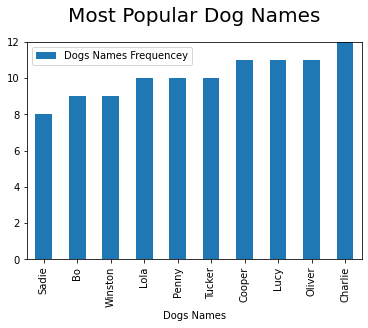

In [74]:
named_dogs = df.query('name == name')
named_dogs_grouped = named_dogs.groupby('name').count()[['tweet_id']]
named_dogs_grouped.rename(columns={'tweet_id':'name_count'}, inplace=True)
named_dogs_grouped.query('name_count >= 8').sort_values(by=['name_count']).plot.bar()
plt.ylim(top=12)
plt.title("Most Popular Dog Names",{'fontsize': 20},pad=20)
plt.xlabel("Dogs Names")
plt.legend(["Dogs Names Frequencey"])

***Most dog tweet that got favorited***
* the most favorited dog was from `Lakeland Terrier` Bread, it was favorited by 132810 users and retweeted 48265 times. 


In [75]:
df[df.favorite_count == df.favorite_count.max()]

,tweet_id,tweet_date,source,text,name,retweet_count,favorite_count,rating,age_stage,bread
409,822872901745569793,2017-01-21 18:26:02 +0000,iPhone,Here's a super supportive puppo participating ...,NaN,48265.0,132810.0,1.3,puppo,Lakeland_terrier


***Most dog tweet retweeted***
* the most retweeted dog was from `Labrador Retriever` Bread, it was retweeted 79515 times and favorited by 131075 users. 

In [76]:
df[df.retweet_count == df.retweet_count.max()]

,tweet_id,tweet_date,source,text,name,retweet_count,favorite_count,rating,age_stage,bread
1023,744234799360020481,2016-06-18 18:26:18 +0000,iPhone,Here's a doggo realizing you can stand in a po...,NaN,79515.0,131075.0,1.3,doggo,Labrador_retriever


In [77]:
df.query('tweet_id == 744234799360020481').text.tolist()

["Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4"]

***Most source of the tweets***
* 94% of the tweets was posted using iPhone twitter app, and that because of the tweets are from @WeRateDogs account.

Text(0, 0.5, '')

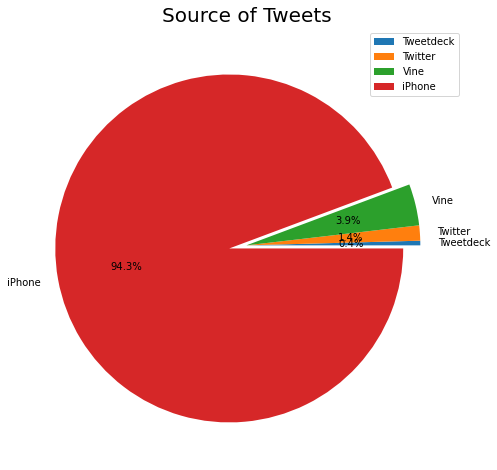

In [78]:
tweet_sources = df.groupby('source').count()[['tweet_id']]
tweet_sources.rename(columns={'tweet_id': 'source_count'}, inplace=True)
tweet_sources['source_percentage'] = tweet_sources.source_count / tweet_sources.source_count.sum() * 100
tweet_sources['source_percentage'].plot.pie(figsize=(10,8), autopct='%1.1f%%',
        explode=(0,0,0,0.1))
plt.title("Source of Tweets", {'fontsize': 20})
plt.legend(["Tweetdeck", "Twitter", "Vine", "iPhone"])
plt.ylabel("")

***Most and least rated bread***
* The distribution of average ratings of the breads is normally distributed with one outlayer with a rating value of 0.5, and max average rating is 1.3
* The top average rating breads are Dumbers with average ratings of 1.3.
* the lowest average rating breads are Japanese Spaniel with rating of 0.5

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

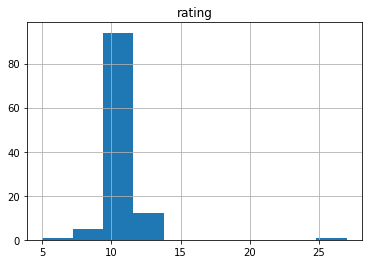

In [79]:
bread_ratings = df.query('bread == bread')[['rating', 'bread']].groupby('bread').mean() * 10
bread_ratings.hist()

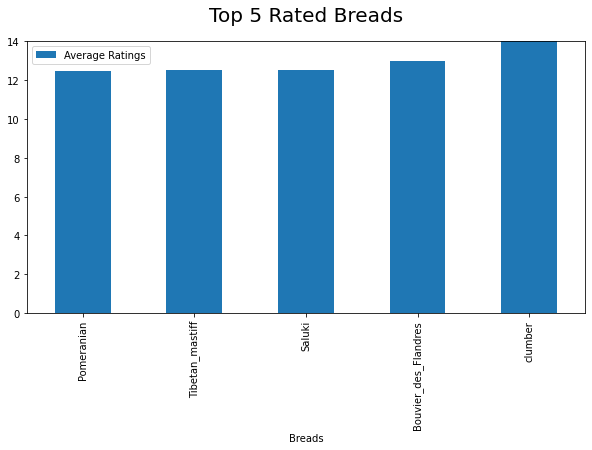

In [80]:
bread_ratings.sort_values(by=['rating']).tail(5).plot.bar(figsize=(10,5))
plt.ylim(top=14)
plt.title("Top 5 Rated Breads",{'fontsize': 20},pad=20)
plt.xlabel("Breads")
plt.legend(["Average Ratings"])

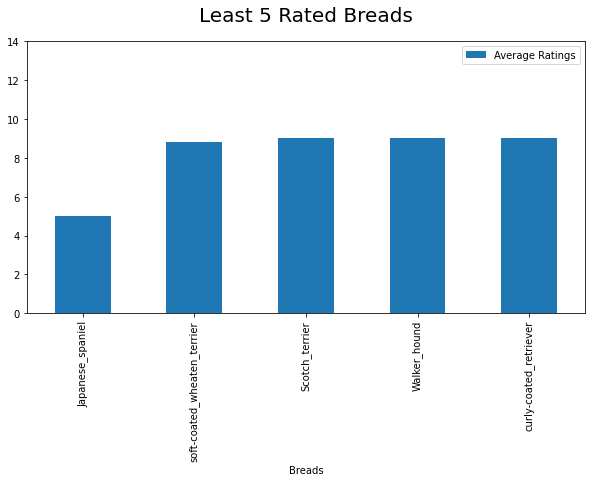

In [81]:
bread_ratings.sort_values(by=['rating']).head(5).plot.bar(figsize=(10,5))
plt.ylim(top=14)
plt.title("Least 5 Rated Breads",{'fontsize': 20},pad=20)
plt.xlabel("Breads")
plt.legend(["Average Ratings"])

In [82]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'wrangle_act.ipynb'])

1

### References
* https://www.kaggle.com/code/msytnadeem/weratedogs-tweet-data-wrangling